<a href="https://colab.research.google.com/github/4LC4NT4R4/XMLD/blob/improved_vortex_class/poo_xmld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import os
from datetime import datetime


%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Coleta de dados


In [75]:
class Spectrum():

    def __init__(self, x, y, pre=None, pos=None, E0=None, Ei=None, Ef=None, shift=None, name=None, legend=None):
        self.name = name
        self.legend = legend
        self.x = np.array(x)
        self.y = np.array(y)
        self.f = None
        self.p = None
        self.Ei=Ei #Cut the x,y data bellow Ei
        self.Ef=Ef #Cut the x,y data above Ef
        self.shift=shift #Energy shift
        self.dy_dx = np.gradient(y, x) #Derivative of y with repect to x
        self.E0 = E0 #Energy theshhold

        if self.Ei is not None:
            mask_Ei = self.x >= self.Ei
            self.x=self.x[mask_Ei]
            self.y=self.y[mask_Ei]

        if self.Ef is not None:
            mask_Ef = self.x <= self.Ef
            self.x=self.x[mask_Ef]
            self.y=self.y[mask_Ef]

        if self.shift is not None:
            self.x+=self.shift/1000

        # if E0 is not given, set E0 as the maximum of derivative
        if self.E0 is None:
            self.E0 = self.x[np.argmax(self.y)]

        # Verifica se pre e pos foram passados; se não, atribui valores padrão
        self.pre = pre if pre is not None else [-90, -40]
        self.pos = pos if pos is not None else [31, 142]

        # Normaliza usando o método norm
        self.norm_y = self.norm(self.x, self.y, self.E0, pre_edge=self.pre, pos_edge=self.pos)

    # Normalização de energia em eV
    def norm(self, x, y, e0, pre_edge, pos_edge, n=1, m=1, flattering=True):
        X = np.array(x, dtype='float')
        Y = np.array(y, dtype='float')

        # Pré-borda (pre-edge)
        mask_pre = (X >= e0 + (pre_edge[0] / 1000)) & (X <= e0 + (pre_edge[1] / 1000))
        x_pre = X[mask_pre]
        y_pre = Y[mask_pre]

        # Ajuste polinomial para a pré-borda
        coefficients_pre = np.polyfit(x_pre, y_pre, n)
        p = np.poly1d(coefficients_pre)
        self.p = p

        # Pós-borda (post-edge)
        mask_pos = (X >= e0 + (pos_edge[0] / 1000)) & (X <= e0 + (pos_edge[1] / 1000))
        x_pos = X[mask_pos]
        y_pos = Y[mask_pos]

        # Ajuste polinomial para a pós-borda
        coefficients_pos = np.polyfit(x_pos, y_pos, m)
        f = np.poly1d(coefficients_pos)
        self.f=f

        # Cálculo do edge step
        edge_step = f(e0) - p(e0)

        # Normalização
        if flattering:
            Y = Y - p(X) * (1 - np.heaviside(X - e0, 1))
            Y = Y + (edge_step - f(X)) * np.heaviside(X - e0, 1)
            Y = Y / edge_step
        else:
            Y = Y - p(X)
            Y = Y / edge_step

        return Y


    def plot_normalized(self):
        fig, ax =plt.subplots()
        ax.plot(self.x, self.norm_y)
        plt.plot()

    def plot_parameters(self):
        fig, ax =plt.subplots()
        ax.plot(self.x, self.y)
        ax.plot(self.x,self.f(self.x))
        ax.plot(self.x,self.p(self.x))
        ax.axvline(x=self.E0+self.pre[0]/1000, color='r', linestyle='--')
        ax.axvline(x=self.E0+self.pre[1]/1000, color='r', linestyle='--')
        ax.axvline(x=self.E0+self.pos[0]/1000, color='g', linestyle='--')
        ax.axvline(x=self.E0+self.pos[1]/1000, color='g', linestyle='--')
        plt.plot()






In [80]:
class Vortex:
    def __init__(self, path=None, **kwargs):
        """
        Inicializa a classe Vortex. Pode-se fornecer um caminho para um arquivo CSV (path)
        ou quatro espectros (s1, s2, s3, s4) diretamente através dos argumentos.
        """
        self.path = path
        self.name = None
        self.date = None
        self.legend = None

        # Define atributos padrão com valores especificados em kwargs ou usa os valores padrão
        default_attributes = {
            'roi': 2,
            'shift': None,
            'pre': None,
            'pos': None,
            's1': None,
            's2': None,
            's3': None,
            's4': None
        }
        for key, default in default_attributes.items():
            setattr(self, key, kwargs.get(key, default))

        # Configurações de nome e legenda, se path for fornecido
        if self.path is not None:
            self.name = os.path.basename(path)
            self.legend = '_'.join(self.path.split("_")[1:4])
            self.date = '_'.join(self.path.split("_")[-2:])

        # Carrega os dados ou atribui espectros fornecidos
        if path and not all([self.s1, self.s2, self.s3, self.s4]):
            self.data = self._data(self.path)  # Carregar dados do arquivo
            for i in range(1, 5):
                setattr(self, f's{i}', Spectrum(
                    self.data['Energy'], self.data[f'roi{self.roi}{i}'] / self.data['I0'], pre=self.pre, pos=self.pos
                ))

        # Agrupa os espectros numa lista
        self.spectra = [getattr(self, f's{i}') for i in range(1, 5)]

        # Verificação e configuração adicional
        if not all(self.spectra):
            raise ValueError("Espectros insuficientes ou arquivo de dados não fornecido.")

        # Ajusta os espectros com deslocamento, se necessário
        if self.shift is not None:
            for spectrum in self.spectra:
                spectrum.x += self.shift / 1000

        # Cria um espectro somado
        self.s = Spectrum(self.s1.x, sum(s.y for s in self.spectra))


    def _data(self, path, line_skip=9):
        """
        Método para carregar dados de um arquivo CSV.
        path: caminho para o arquivo
        line_skip: número de linhas a serem ignoradas no início do arquivo
        """
        try:
            with open(path, 'r') as arquivo_csv:
                reader_csv = csv.reader(arquivo_csv)
                m = 0
                df = None

                for line in reader_csv:
                    line = line[0].split()
                    if line[0] == '#L':  # Linha de cabeçalho
                        col = line[1:]  # Remove '#L' e usa o restante como colunas
                        df = pd.DataFrame(columns=col)  # Cria um DataFrame vazio com essas colunas

                    if m >= line_skip and df is not None:  # Começa a ler dados após `line_skip`
                        df.loc[m - line_skip] = [float(item) for item in line]
                    m += 1
            return df

        except Exception as e:
            print(f"Erro ao carregar dados: {e}")
            return None

    def plot_derivative(self):
        """
        Plota as derivadas dos espectros s1, s2, s3 e s4.
        """
        fig, axs = plt.subplots()
        axs.plot(self.s1.x, self.s1.dy_dx, marker='1', label='ROI1')
        axs.plot(self.s2.x, self.s2.dy_dx, marker='2', label='ROI2')
        axs.plot(self.s3.x, self.s3.dy_dx, marker='3', label='ROI3')
        axs.plot(self.s4.x, self.s4.dy_dx, marker='4', label='ROI4')
        axs.set_xlabel("Energy (eV)")
        axs.set_ylabel("dY/dX")
        axs.legend()
        plt.show()

    def plot_alignment(self):
        """
        Plota os dados brutos (não normalizados) dos espectros s1, s2, s3 e s4.
        """
        fig, ax = plt.subplots(2, 2, sharex='col')

        ax[0, 0].plot(self.s1.x, self.s1.y, 'r-')
        ax[0, 0].plot(self.s1.x, self.s1.f(self.s1.x))
        ax[0, 0].plot(self.s1.x, self.s1.p(self.s1.x))
        ax[0, 0].axvline(x=self.s1.E0+self.s1.pre[0]/1000, color='r', linestyle='--')
        ax[0, 0].axvline(x=self.s1.E0+self.s1.pre[1]/1000, color='r', linestyle='--')
        ax[0, 0].axvline(x=self.s1.E0+self.s1.pos[0]/1000, color='g', linestyle='--')
        ax[0, 0].axvline(x=self.s1.E0+self.s1.pos[1]/1000, color='g', linestyle='--')
        ax[0, 0].set_title('Gráfico 1')

        ax[0, 1].plot(self.s2.x, self.s2.y, 'g-')
        ax[0, 1].plot(self.s2.x, self.s2.f(self.s2.x))
        ax[0, 1].plot(self.s2.x, self.s2.p(self.s2.x))
        ax[0, 1].axvline(x=self.s2.E0+self.s2.pre[0]/1000, color='r', linestyle='--')
        ax[0, 1].axvline(x=self.s2.E0+self.s2.pre[1]/1000, color='r', linestyle='--')
        ax[0, 1].axvline(x=self.s2.E0+self.s2.pos[0]/1000, color='g', linestyle='--')
        ax[0, 1].axvline(x=self.s2.E0+self.s2.pos[1]/1000, color='g', linestyle='--')
        ax[0, 1].set_title('Gráfico 2')

        ax[1, 0].plot(self.s3.x, self.s3.y, 'b-')
        ax[1, 0].plot(self.s3.x, self.s3.f(self.s3.x))
        ax[1, 0].plot(self.s3.x, self.s3.p(self.s3.x))
        ax[1, 0].axvline(x=self.s3.E0+self.s3.pre[0]/1000, color='r', linestyle='--')
        ax[1, 0].axvline(x=self.s3.E0+self.s3.pre[1]/1000, color='r', linestyle='--')
        ax[1, 0].axvline(x=self.s3.E0+self.s3.pos[0]/1000, color='g', linestyle='--')
        ax[1, 0].axvline(x=self.s3.E0+self.s3.pos[1]/1000, color='g', linestyle='--')
        ax[1, 0].set_title('Gráfico 3')

        ax[1, 1].plot(self.s4.x, self.s4.y, 'y-')
        ax[1, 1].plot(self.s4.x, self.s4.f(self.s4.x))
        ax[1, 1].plot(self.s4.x, self.s4.p(self.s4.x))
        ax[1, 1].axvline(x=self.s4.E0+self.s4.pre[0]/1000, color='r', linestyle='--')
        ax[1, 1].axvline(x=self.s4.E0+self.s4.pre[1]/1000, color='r', linestyle='--')
        ax[1, 1].axvline(x=self.s4.E0+self.s4.pos[0]/1000, color='g', linestyle='--')
        ax[1, 1].axvline(x=self.s4.E0+self.s4.pos[1]/1000, color='g', linestyle='--')
        ax[1, 1].set_title('Gráfico 4')

        plt.tight_layout()
        plt.show()

    def plot_normalized(self):
        """
        Plota os dados normalizados dos espectros s1, s2, s3 e s4.
        """
        fig, ax = plt.subplots(2, 2, sharex='col')

        ax[0, 0].plot(self.s1.x, self.s1.norm_y, 'r-')
        ax[0, 0].set_title('Gráfico 1')

        ax[0, 1].plot(self.s2.x, self.s2.norm_y, 'g-')
        ax[0, 1].set_title('Gráfico 2')

        ax[1, 0].plot(self.s3.x, self.s3.norm_y, 'b-')
        ax[1, 0].set_title('Gráfico 3')

        ax[1, 1].plot(self.s4.x, self.s4.norm_y, 'y-')
        ax[1, 1].set_title('Gráfico 4')

        plt.tight_layout()
        plt.show()


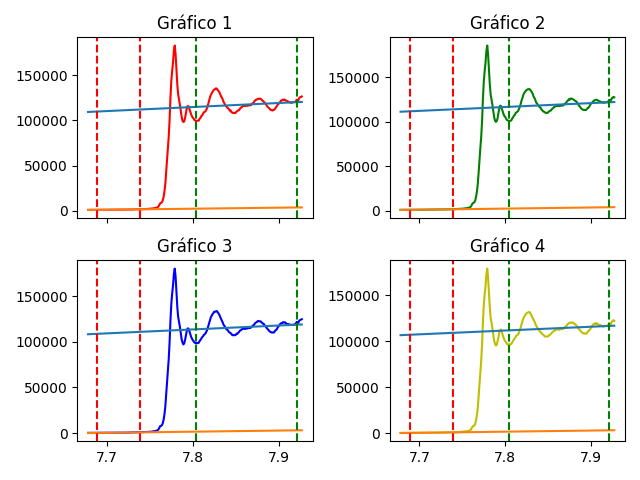

B4_p40kp13_RT_1_A04062023_053631.csv
p40kp13_RT_1
A04062023_053631.csv


In [82]:
arq_1='B4_p40kp13_RT_1_A04062023_053631'
arq_2='B4_p40kp13_RT_3_A04062023_061749'
arq_3='B4_p40kp13_LT_1_A04062023_020113'
arq_4='B4_p40kp13_LT_3_A04062023_025315'

path='/content/drive/MyDrive/JupyterPrograms/XMLD/data/'

c=Vortex(path+arq_1+'.csv', pos=[25,142])
c.plot_raw_data()
print(c.name)
print(c.legend)
print(c.date)

# s=Spectrum(c.data['Energy'],c.data['roi21'], pos=[25,142])
# s.plot_parameters()
# s.plot_normalized()



# Data visualization

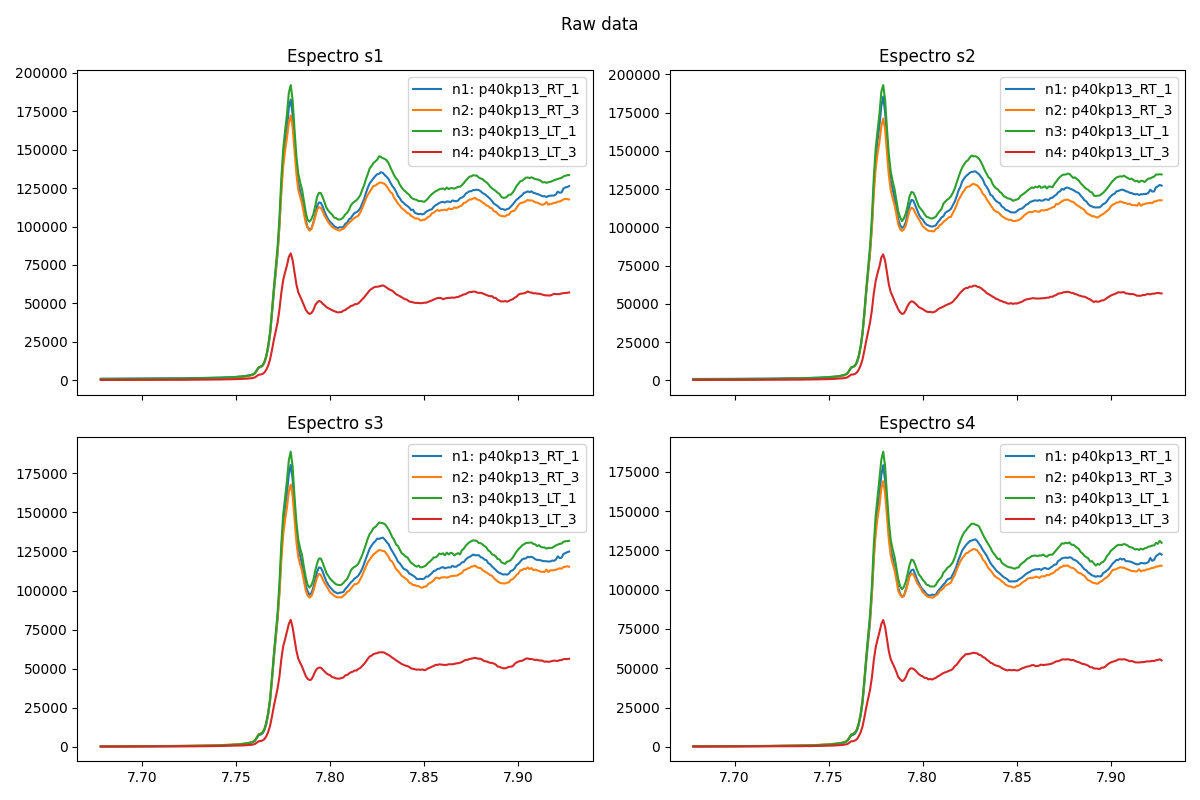

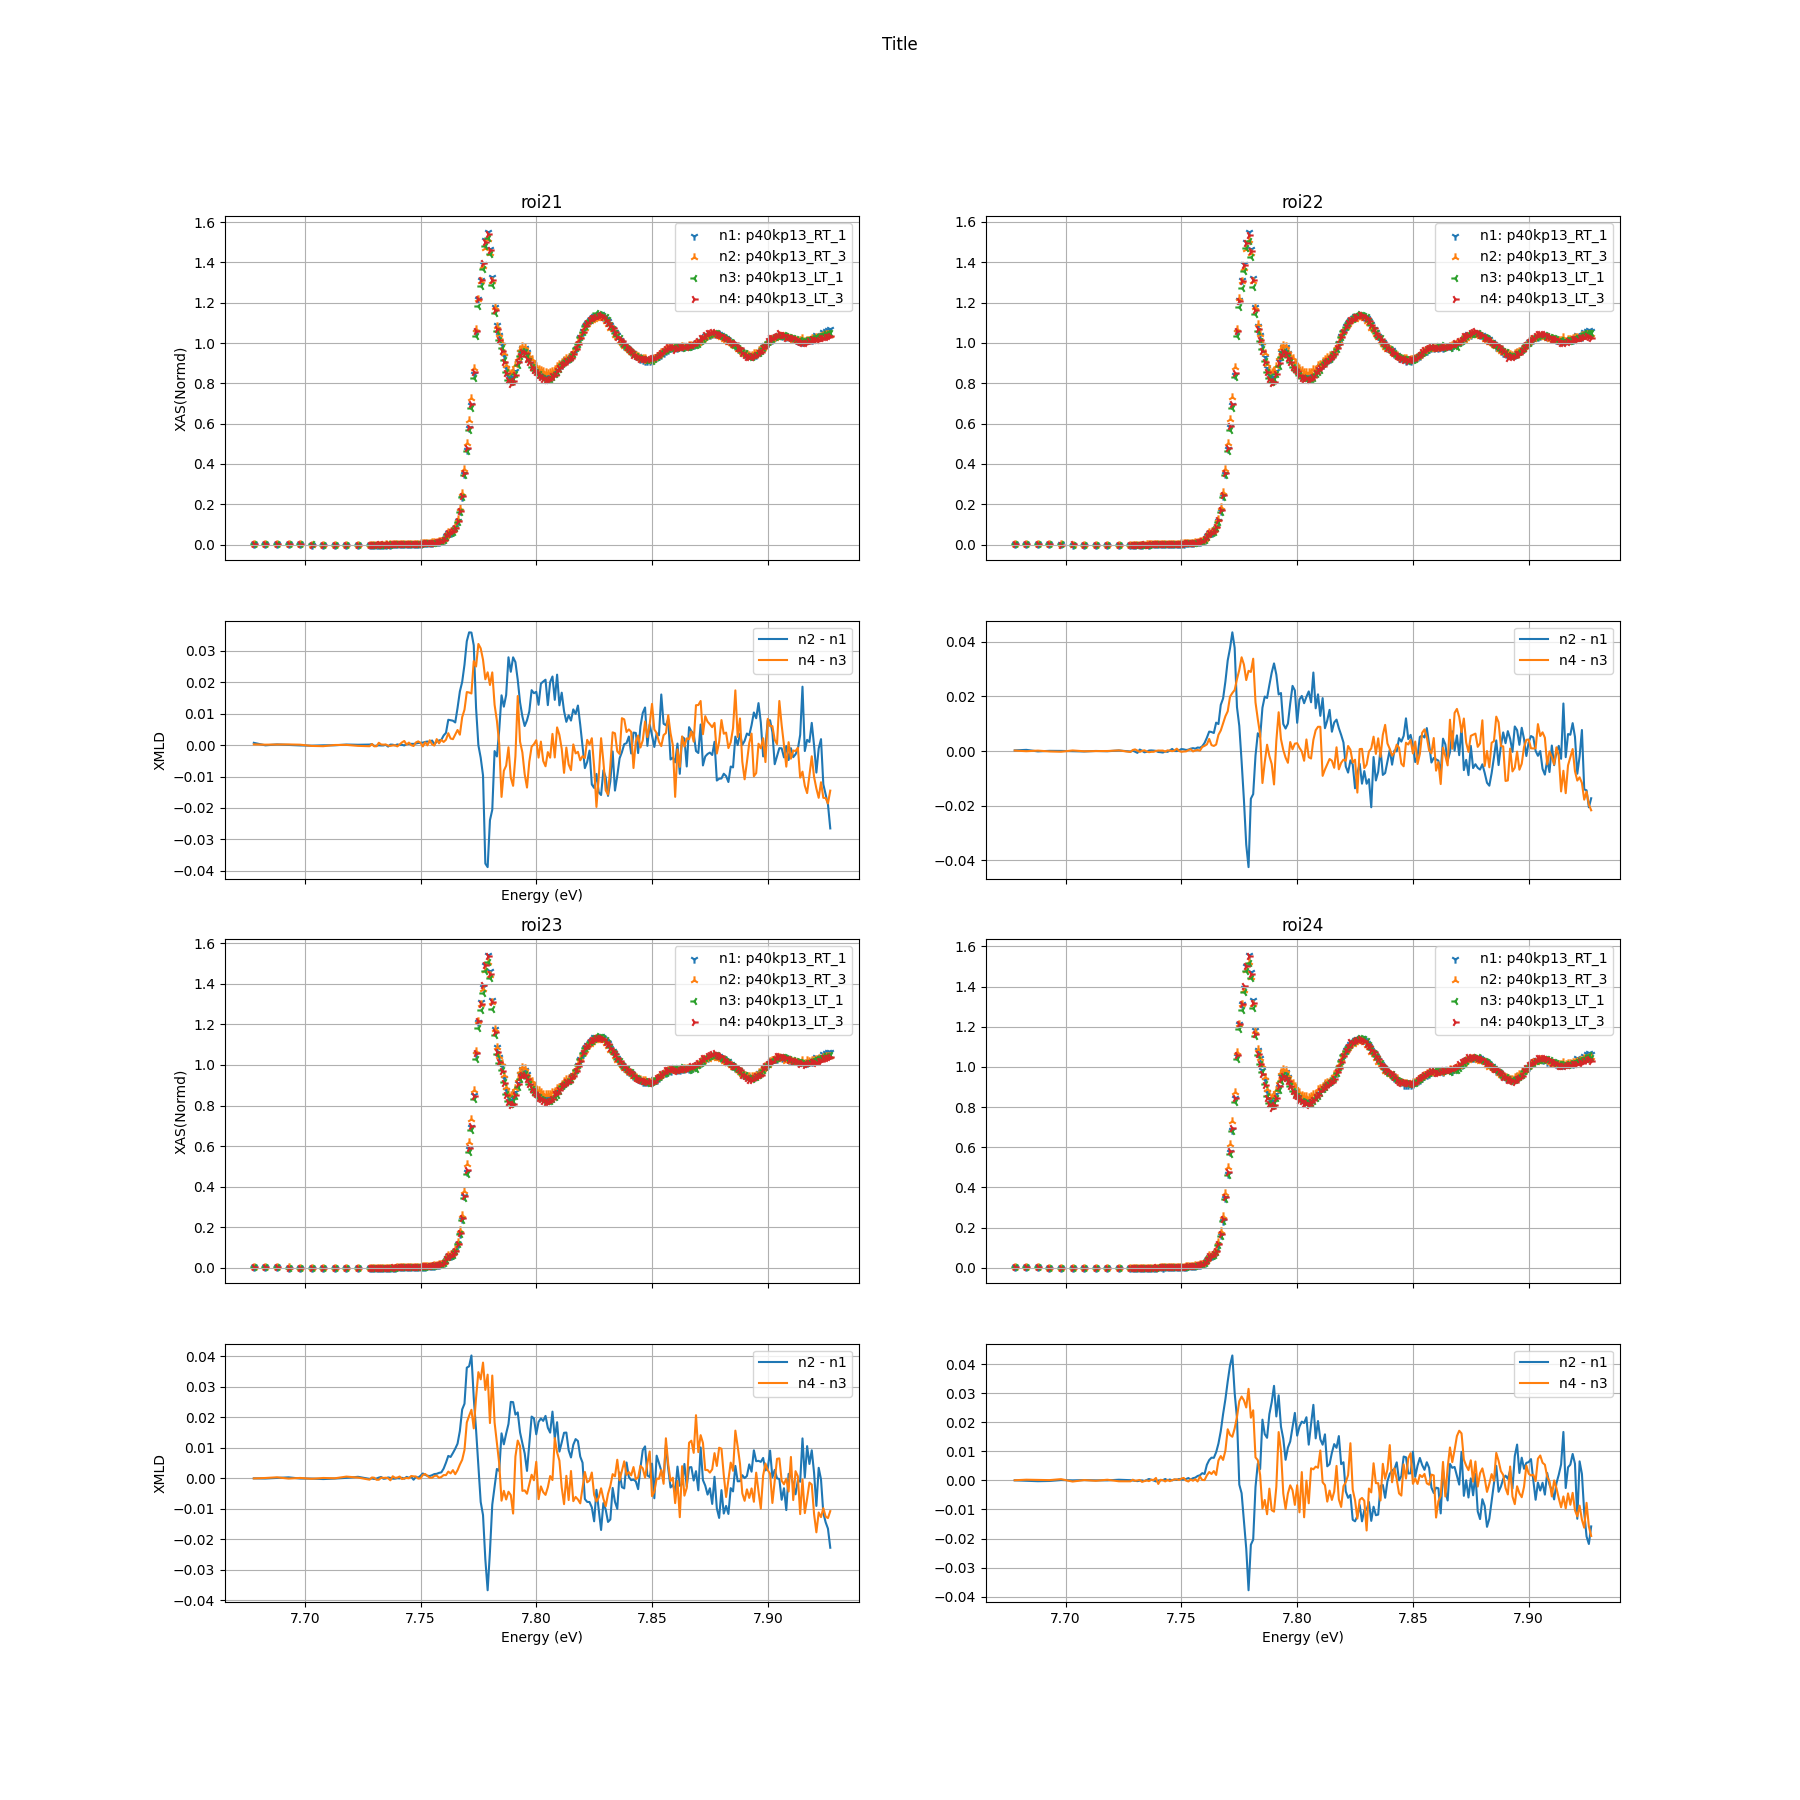

In [85]:
class xmld4:
    def __init__(self, arq1, arq2, arq3, arq4, title=None, shift=None):
        self.title = title
        self.shift=shift

        #Dados Brutos
        self.v1 = Vortex(arq1,shift=self.shift)
        self.v2 = Vortex(arq2,shift=self.shift)
        self.v3 = Vortex(arq3,shift=self.shift)
        self.v4 = Vortex(arq4,shift=self.shift)

        self.n1 = self.v1

        # Interpolação entre os dados
        self.n2 = Vortex(
            s1=Spectrum(self.n1.s1.x, np.interp(self.n1.s1.x, self.v2.s1.x, self.v2.s1.y)),
            s2=Spectrum(self.n1.s2.x, np.interp(self.n1.s2.x, self.v2.s2.x, self.v2.s2.y)),
            s3=Spectrum(self.n1.s3.x, np.interp(self.n1.s3.x, self.v2.s3.x, self.v2.s3.y)),
            s4=Spectrum(self.n1.s4.x, np.interp(self.n1.s4.x, self.v2.s4.x, self.v2.s4.y))
        )
        self.n2.name=self.v2.name
        self.n2.legend=self.v2.legend
        self.n2.date=self.v2.date

        self.n3 = Vortex(
            s1=Spectrum(self.n1.s1.x, np.interp(self.n1.s1.x, self.v3.s1.x, self.v3.s1.y)),
            s2=Spectrum(self.n1.s2.x, np.interp(self.n1.s2.x, self.v3.s2.x, self.v3.s2.y)),
            s3=Spectrum(self.n1.s3.x, np.interp(self.n1.s3.x, self.v3.s3.x, self.v3.s3.y)),
            s4=Spectrum(self.n1.s4.x, np.interp(self.n1.s4.x, self.v3.s4.x, self.v3.s4.y))
        )
        self.n3.name=self.v3.name
        self.n3.legend=self.v3.legend
        self.n3.date=self.v3.date

        self.n4 = Vortex(
            s1=Spectrum(self.n1.s1.x, np.interp(self.n1.s1.x, self.v4.s1.x, self.v4.s1.y)),
            s2=Spectrum(self.n1.s2.x, np.interp(self.n1.s2.x, self.v4.s2.x, self.v4.s2.y)),
            s3=Spectrum(self.n1.s3.x, np.interp(self.n1.s3.x, self.v4.s3.x, self.v4.s3.y)),
            s4=Spectrum(self.n1.s4.x, np.interp(self.n1.s4.x, self.v4.s4.x, self.v4.s4.y))
        )

        self.n4.name=self.v4.name
        self.n4.legend=self.v4.legend
        self.n4.date=self.v4.date

    def plot_rois(self):
        # Cria a figura e os subplots
        fig, axs = plt.subplots(4, 2, figsize=(18, 18), gridspec_kw={'height_ratios': [4, 3, 4, 3]}, sharex=True)
        fig.suptitle(self.title or 'Title')

        l = 0
        m = 0

        for i, ax in enumerate(axs.flatten()):

            if i == 0 or i == 1 or i == 4 or i == 5:
                if i == 0 or i == 4:
                    ax.set_ylabel('XAS(Normd)')
                ax.set_title(f'roi2{l+1}')

                # Definir os dados de espectro para o subplot
                x1, y1 = self.n1.spectra[l].x, self.n1.spectra[l].norm_y
                x2, y2 = self.n2.spectra[l].x, self.n2.spectra[l].norm_y
                x3, y3 = self.n3.spectra[l].x, self.n3.spectra[l].norm_y
                x4, y4 = self.n4.spectra[l].x, self.n4.spectra[l].norm_y

                # Plotar os dados
                ax.scatter(x1, y1, marker='1', label=f'n1: {self.n1.legend}')
                ax.scatter(x2, y2, marker='2', label=f'n2: {self.n2.legend}')
                ax.scatter(x3, y3, marker='3', label=f'n3: {self.n3.legend}')
                ax.scatter(x4, y4, marker='4', label=f'n4: {self.n4.legend}')

                ax.grid()
                ax.legend()
                l += 1

            elif i == 2 or i == 3 or i == 6 or i == 7:

                # Diferença entre os espectros
                diff1 = self.n2.spectra[m].norm_y - self.n1.spectra[m].norm_y
                diff2 = self.n4.spectra[m].norm_y - self.n3.spectra[m].norm_y

                ax.plot(self.n1.spectra[m].x, diff1, label='n2 - n1')
                ax.plot(self.n3.spectra[m].x, diff2, label='n4 - n3')

                if i == 6 or i == 7 or i == 2:
                    ax.set_xlabel('Energy (eV)')
                if i == 2 or i == 6:
                    ax.set_ylabel('XMLD')

                ax.grid()
                ax.legend()
                m += 1

    def plot(self):
        # Crie a figura e os eixos com ajuste de espaçamento vertical e proporções de altura
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(4, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
        #plt.subplots_adjust(hspace=0)

        # Plote o primeiro gráfico
        ax1.scatter(self.n1.s.x, self.n1.s.norm_y,  marker='1', label=f'n1: {self.n1.legend}')
        ax1.scatter(self.n2.s.x, self.n2.s.norm_y,  marker='2', label=f'n2: {self.n2.legend}')
        ax1.scatter(self.n3.s.x, self.n3.s.norm_y,  marker='3', label=f'n3: {self.n3.legend}')
        ax1.scatter(self.n4.s.x, self.n4.s.norm_y,  marker='4', label=f'n4: {self.n4.legend}')
        ax1.grid()
        ax1.legend()
        ax1.set_ylabel('XAS (Normalizado)')


        # Plote o segundo gráfico no mesmo eixo
        ax2.plot(self.n1.s.x,self.n2.s.norm_y-self.n1.s.norm_y, label='n2-n1')
        ax2.plot(self.n3.s.x,self.n4.s.norm_y-self.n3.s.norm_y, label='n4-n3')
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel('Energia (eV)')
        ax2.set_ylabel('XMLD')


        # Exiba o gráfico
        plt.tight_layout()

        plt.show()

    def plot_alignment(self):
        """
        Plota 4 gráficos, dois em cima e dois em baixo.
        Cada gráfico plota espectros equivalentes (s1, s2, s3, s4) de cada classe Vortex.
        """
        fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
        fig.suptitle('Raw data')

        # Plota os espectros s1
        axs[0, 0].plot(self.n1.s1.x, self.n1.s1.y, label=f'n1: {self.n1.legend}')
        axs[0, 0].plot(self.n2.s1.x, self.n2.s1.y, label=f'n2: {self.n2.legend}')
        axs[0, 0].plot(self.n3.s1.x, self.n3.s1.y, label=f'n3: {self.n3.legend}')
        axs[0, 0].plot(self.n4.s1.x, self.n4.s1.y, label=f'n4: {self.n4.legend}')
        axs[0, 0].set_title('Espectro s1')
        axs[0, 0].legend()

        # Plota os espectros s2
        axs[0, 1].plot(self.n1.s2.x, self.n1.s2.y, label=f'n1: {self.n1.legend}')
        axs[0, 1].plot(self.n2.s2.x, self.n2.s2.y, label=f'n2: {self.n2.legend}')
        axs[0, 1].plot(self.n3.s2.x, self.n3.s2.y, label=f'n3: {self.n3.legend}')
        axs[0, 1].plot(self.n4.s2.x, self.n4.s2.y, label=f'n4: {self.n4.legend}')
        axs[0, 1].set_title('Espectro s2')
        axs[0, 1].legend()

        # Plota os espectros s3
        axs[1, 0].plot(self.n1.s3.x, self.n1.s3.y, label=f'n1: {self.n1.legend}')
        axs[1, 0].plot(self.n2.s3.x, self.n2.s3.y, label=f'n2: {self.n2.legend}')
        axs[1, 0].plot(self.n3.s3.x, self.n3.s3.y, label=f'n3: {self.n3.legend}')
        axs[1, 0].plot(self.n4.s3.x, self.n4.s3.y, label=f'n4: {self.n4.legend}')
        axs[1, 0].set_title('Espectro s3')
        axs[1, 0].legend()

        # Plota os espectros s4
        axs[1, 1].plot(self.n1.s4.x, self.n1.s4.y, label=f'n1: {self.n1.legend}')
        axs[1, 1].plot(self.n2.s4.x, self.n2.s4.y, label=f'n2: {self.n2.legend}')
        axs[1, 1].plot(self.n3.s4.x, self.n3.s4.y, label=f'n3: {self.n3.legend}')
        axs[1, 1].plot(self.n4.s4.x, self.n4.s4.y, label=f'n4: {self.n4.legend}')
        axs[1, 1].set_title('Espectro s4')
        axs[1, 1].legend()


        plt.tight_layout()
        plt.show()




# Exemplo de uso
arq1 = 'B4_p40kp13_RT_1_A04062023_053631'
arq2 = 'B4_p40kp13_RT_3_A04062023_061749'
arq3 = 'B4_p40kp13_LT_1_A04062023_020113'
arq4 = 'B4_p40kp13_LT_3_A04062023_025315'

path = '/content/drive/MyDrive/JupyterPrograms/XMLD/data/'

# Instanciando e plotando
a = xmld4(path + arq1 + '.csv', path + arq2 + '.csv', path + arq3 + '.csv', path + arq4 + '.csv')
a.plot_rois()
a.plot_alignment()
#a.plot()


In [7]:
# prompt: Quero fazer uma função que gere uma figura usando matplotlib . A função recebe um numero n de classes axmld4. A função deve plotar o mesmo padrão de xmld4.plot() porém para cada plot de xmld4 deve haver um parametro organize um deslocamento vertical entre os plots

def plot_multiple_xmld4(xmld4_list, vertical_shift=0.1):
  """
  Plota vários objetos xmld4 em um único gráfico com deslocamento vertical.

  Args:
    xmld4_list: Uma lista de objetos xmld4 a serem plotados.
    vertical_shift: O valor do deslocamento vertical entre os plots.
  """

  fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

  for i, xmld4_obj in enumerate(xmld4_list):
    # Deslocamento vertical para cada plot
    y_shift = i * vertical_shift

    # Plota XAS normalizado no primeiro eixo
    ax1.scatter(xmld4_obj.n1.s.x, xmld4_obj.n1.s.norm_y + y_shift, marker='1', label=f'n1: {xmld4_obj.n1.legend}:{xmld4_obj.n1.date}')
    ax1.scatter(xmld4_obj.n2.s.x, xmld4_obj.n2.s.norm_y + y_shift, marker='2', label=f'n2: {xmld4_obj.n2.legend}:{xmld4_obj.n2.date}')
    ax1.scatter(xmld4_obj.n3.s.x, xmld4_obj.n3.s.norm_y + y_shift, marker='3', label=f'n3: {xmld4_obj.n3.legend}:{xmld4_obj.n3.date}')
    ax1.scatter(xmld4_obj.n4.s.x, xmld4_obj.n4.s.norm_y + y_shift, marker='4', label=f'n4: {xmld4_obj.n4.legend}:{xmld4_obj.n4.date}')


    # Plota XMLD no segundo eixo
    ax2.plot(xmld4_obj.n1.s.x, (xmld4_obj.n2.s.norm_y - xmld4_obj.n1.s.norm_y) + y_shift, label=f'n2-n1: {xmld4_obj.n2.legend}')
    ax2.plot(xmld4_obj.n3.s.x, (xmld4_obj.n4.s.norm_y - xmld4_obj.n3.s.norm_y) + y_shift, label=f'n4-n3: {xmld4_obj.n4.legend}')

  ax1.grid()
  ax1.legend()
  ax1.set_ylabel('XAS (Normalizado)')

  ax2.legend()
  ax2.grid()
  ax2.set_xlabel('Energia (eV)')
  ax2.set_ylabel('XMLD')

  plt.tight_layout()
  plt.show()



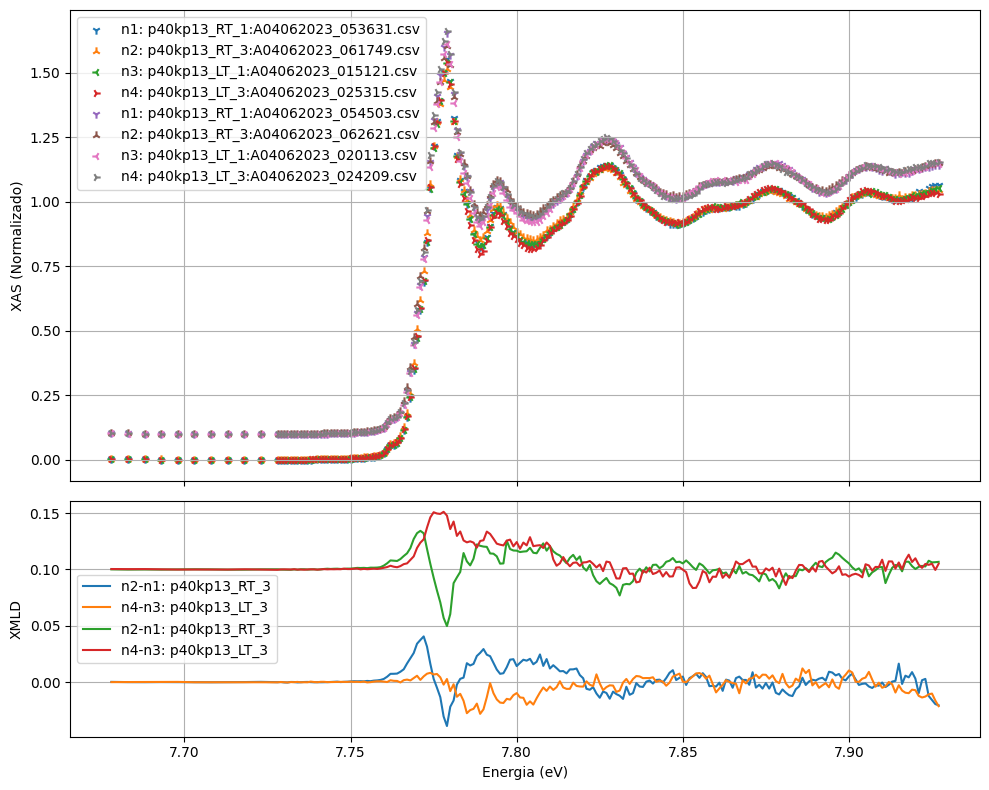

In [8]:
# Exemplo de uso

path = '/content/drive/MyDrive/JupyterPrograms/XMLD/data/'

arq1 = 'B4_p40kp13_RT_1_A04062023_053631.csv'
arq2 = 'B4_p40kp13_RT_3_A04062023_061749.csv'
arq3 = 'B4_p40kp13_LT_1_A04062023_015121.csv'
arq4 = 'B4_p40kp13_LT_3_A04062023_025315.csv'

a = xmld4(path + arq1 , path + arq2, path + arq3, path + arq4)

arq1 = 'B4_p40kp13_RT_1_A04062023_054503.csv'
arq2 = 'B4_p40kp13_RT_3_A04062023_062621.csv'
arq3 = 'B4_p40kp13_LT_1_A04062023_020113.csv'
arq4 = 'B4_p40kp13_LT_3_A04062023_024209.csv'

b = xmld4(path + arq1 , path + arq2, path + arq3, path + arq4)


# Instanciando e plotando

plot_multiple_xmld4([a, b])

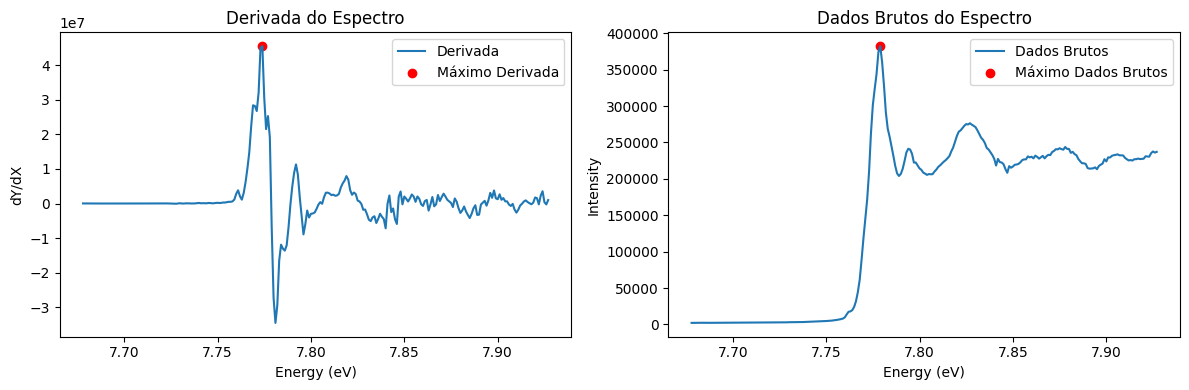

In [ ]:
x=df1['Energy'].to_numpy()
y=df1['roi21'].to_numpy()
teste=Spectrum(x,y)
teste.align()

In [ ]:
Faça uma cópia da minha classe vortex, e adicione uma função que plota lado a lado  dois plots. No primeiro deve conter a derivada de cada um dos 4 espectros contidos na classe, destaque os máximos de cada derivada. No segundo plot deve conter os dados brutos de cada espectro, novamente destaque os máximos

In [ ]:
# prompt: Adicione uma função a minha classe xmld4 que plot 4 gráficos dois em cima e dois em baixo. cada gráfico deve plotar espectros equivalentes, por exemplo no primeiro eixo plot os s1 de cada classe vortex e assim por diante

class xmld4:
    # ... (rest of your xmld4 class code) ...

    def plot_individual_spectra(self):
        """
        Plota 4 gráficos, dois em cima e dois em baixo.
        Cada gráfico plota espectros equivalentes (s1, s2, s3, s4) de cada classe Vortex.
        """
        fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
        fig.suptitle('Espectros Individuais')

        # Plota os espectros s1
        axs[0, 0].plot(self.n1.s1.x, self.n1.s1.norm_y, label=f'n1: {self.n1.legend}')
        axs[0, 0].plot(self.n2.s1.x, self.n2.s1.norm_y, label=f'n2: {self.n2.legend}')
        axs[0, 0].plot(self.n3.s1.x, self.n3.s1.norm_y, label=f'n3: {self.n3.legend}')
        axs[0, 0].plot(self.n4.s1.x, self.n4.s1.norm_y, label=f'n4: {self.n4.legend}')
        axs[0, 0].set_title('Espectro s1')
        axs[0, 0].legend()

        # Plota os espectros s2
        axs[0, 1].plot(self.n1.s2.x, self.n1.s2.norm_y, label=f'n1: {self.n1.legend}')
        axs[0, 1].plot(self.n2.s2.x, self.n2.s2.norm_y, label=f'n2: {self.n2.legend}')
        axs[0, 1].plot(self.n3.s2.x, self.n3.s2.norm_y, label=f'n3: {self.n3.legend}')
        axs[0, 1].plot(self.n4.s2.x, self.n4.s2.norm_y, label=f'n4: {self.n4.legend}')
        axs[0, 1].set_title('Espectro s2')
        axs[0, 1].legend()

        # Plota os espectros s3
        axs[1, 0].plot(self.n1.s3.x, self.n1.s3.norm_y, label=f'n1: {self.n1.legend}')
        axs[1, 0].plot(self.n2.s3.x, self.n2.s3.norm_y, label=f'n2: {self.n2.legend}')
        axs[1, 0].plot(self.n3.s3.x, self.n3.s3.norm_y, label=f'n3: {self.n3.legend}')
        axs[1, 0].plot(self.n4.s3.x, self.n4.s3.norm_y, label=f'n4: {self.n4.legend}')
        axs[1, 0].set_title('Espectro s3')
        axs[1, 0].legend()

        # Plota os espectros s4
        axs[1, 1].plot(self.n1.s4.x, self.n1.s4.norm_y, label=f'n1: {self.n1.legend}')
        axs[1, 1].plot(self.n2.s4.x, self.n2.s4.norm_y, label=f'n2: {self.n2.legend}')
        axs[1, 1].plot(self.n3.s4.x, self.n3.s4.norm_y, label=f'n3: {self.n3.legend}')
        axs[1, 1].plot(self.n4.s4.x, self.n4.s4.norm_y, label=f'n4: {self.n4.legend}')
        axs[1, 1].set_title('Espectro s4')
        axs[1, 1].legend()


        plt.tight_layout()
        plt.show()


# ... (rest of your code) ...
